In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
os.chdir('/home/sebastiaan/PhD/Repositories/immune_response_detection/')

from statsmodels.stats.multitest import fdrcorrection
from sklearn.metrics import auc
from Levenshtein import distance as levenshtein_distance
from raptcr.constants.parsing import parse_yfv_repertoires
from raptcr.indexing import FlatIndex
from raptcr.hashing import TCRDistEncoder
from raptcr.background import SyntheticBackground
from raptcr.neighbors import NeighborEnrichment
from raptcr.background import generate_olga_sequences_multi
from raptcr.neighbors import tcr_dict_to_df, index_neighbors

plt.rcParams["font.family"] = "monospace"

Read YFV repertoires

In [2]:
day_15 = parse_yfv_repertoires("./data/yfv/P1_15_F1_.txt.gz")

encoder = TCRDistEncoder(aa_dim=8, full_tcr=True)
neighbor_counter = NeighborEnrichment(repertoire=day_15, hasher=encoder, radius=12.5)
neighbor_counter.compute_neighbors()

In [120]:
df = pd.read_csv("/home/sebastiaan/Desktop/P1_15_F1_vcdr3.txt", sep='\t')
df["v_call"] = df.v_call.apply(lambda x: x.split("*")[0]+"*01")
df["j_call"] = df.j_call.apply(lambda x: x.split("*")[0]+"*01")
df.to_csv("/home/sebastiaan/Desktop/P1_15_F1_vcdr3.txt", sep='\t' ,index=False)

ALICE hits

In [3]:
colnames = ["donor","read_count","frequency","junction","junction_aa","v_gene","j_gene","d","total_n","space","space_n","q","pval"]
to_keep = ["donor","read_count","frequency","junction","junction_aa","v_gene","j_gene","q","pval"]
alice = pd.read_csv("./data/yfv/Pogorelyy_hits.tsv.gz", sep="\t", compression="gzip")
alice.columns = colnames
alice = alice[to_keep]

p1_15_alice = alice[alice.donor=="P1_15_F1"].sort_values(by="pval")
p1_15_alice

,donor,read_count,frequency,junction,junction_aa,v_gene,j_gene,q,pval
954,P1_15_F1,1,5.444947e-07,TGCAGTGCCAGGGAAGGGGGGGTAACTGAAGTTTTCTTT,CSAREGGVTEVFF,TRBV20-1,TRBJ1-1,9.41,1.408126e-35
969,P1_15_F1,1,5.444947e-07,TGCAGTGCTAGAGAAGGCGGGGTACCTGAAGCTTTCTTT,CSAREGGVPEAFF,TRBV20-1,TRBJ1-1,9.41,2.950455e-35
964,P1_15_F1,2,1.088989e-06,TGCAGTGCTAGAGAAGGAGGCGTCAATGAAGCTTTCTTT,CSAREGGVNEAFF,TRBV20-1,TRBJ1-1,9.41,4.093814e-34
1037,P1_15_F1,1,5.444947e-07,TGCAGTGCTAGAGAGGGGGGGGTCCGTGAAGCTTTCTTT,CSAREGGVREAFF,TRBV20-1,TRBJ1-1,9.41,3.799574e-33
1097,P1_15_F1,1,5.444947e-07,TGCAGTGCTAGAGATTCGGGGGGAACTGAAGATTTCTTT,CSARDSGGTEDFF,TRBV20-1,TRBJ1-1,9.41,1.056382e-32
...,...,...,...,...,...,...,...,...,...
1455,P1_15_F1,1,5.444947e-07,TGTGCCAGCAGTGATATCTCTGGGGCCAACGTCCTGACTTTC,CASSDISGANVLTF,TRBV6-4,TRBJ2-6,9.41,1.085688e-05
892,P1_15_F1,2,1.088989e-06,TGTGCCATCAGGGAGGGACAGTTAAACACTGAAGCTTTCTTT,CAIREGQLNTEAFF,TRBV10-3,TRBJ1-1,9.41,1.094033e-05
938,P1_15_F1,1,5.444947e-07,TGTGCCAGTAGTATTAGGTCGGCGGATACGCAGTATTTT,CASSIRSADTQYF,TRBV19,TRBJ2-3,9.41,1.095271e-05
907,P1_15_F1,2,1.088989e-06,TGTGCCAGCAGTTTGTGGGGGGAGCAGTTCTTC,CASSLWGEQFF,TRBV12-3,TRBJ2-1,9.41,1.113600e-05


Perform enrichment analysis against pre-vaccination repertoire

In [3]:
print("Reading input")
day_pre0 = parse_yfv_repertoires("./data/yfv/P1_pre0_F1_.txt.gz")

print("Building index")
encoder = TCRDistEncoder(aa_dim=8, full_tcr=True).fit()
index = FlatIndex(hasher=encoder)
index.add(day_pre0)
neighbor_counter.bg_index = index

print("Determining hits")
p = neighbor_counter.compute_pvalues(prefilter=False)

Reading input
Building index
Determining hits
Using background of size 186084.
Computing neighbor counts in background for 74889 sequences.
Performing hypergeometric testing.


Function to extract FPR and TPR from annotated dataframe.

In [4]:
def get_metrics(df, target_col="responding"):
    fp = 0
    tp = 0
    fpr = []
    tpr = []
    for i in df[target_col]:
        if i == False:
            fp += 1
        else:
            tp += 1
        fpr.append(fp)
        tpr.append(tp)
    N = df[target_col].value_counts()[False]
    P = df[target_col].value_counts()[True]
    fpr = [i/N for i in fpr]
    tpr = [i/P for i in tpr]
    return fpr, tpr

def annotate_results(df, responding):
    if "v_gene" not in df.columns:
        df["v_gene"] = df.v_call.apply(lambda x: x.split("*")[0])
    df = df.merge(responding, on=["junction_aa","v_gene"], how="left")
    df["responding"] = df["responding"].fillna("grey")
    df["responding"] = df.responding.map({"red":True,"grey":False})
    return df

def identify_neighbors(n, d=1):
    if n > d:
        return False
    else:
        return True

def get_distance_from_responding(df):
    lds = []
    for i in range(len(df)):
        seq = df.iloc[i]
        cdr3 = seq["junction_aa"]
        v = seq["v_gene"]
        vsub = responding[responding.v_gene==v]
        try:
            lds.append(min([levenshtein_distance(cdr3,j) for j in vsub.junction_aa]))
        except ValueError:
            lds.append(None)
    df['ld'] = lds
    df["hit"] = df.ld.apply(lambda x: identify_neighbors(x))
    return df

### Evaluate performance

Get list of vaccine-responding clones

In [5]:
responding = pd.read_csv("./analysis/background_testing/yfv/yfv_responding.txt", sep="\t")
responding = responding[["bestVGene","CDR3.amino.acid.sequence"]].drop_duplicates()
responding.columns = ["v_gene","junction_aa"]
responding["responding"] = "red"
responding.head()

,v_gene,junction_aa,responding
0,TRBV4-2,CASSQGTAYEQYF,red
1,TRBV4-3,CASSHATGPYEQYF,red
2,TRBV27,CASSYGQGSSYEQYF,red
3,TRBV9,CASSSGTSEGAYEQYF,red
4,TRBV2,CASNRGGGSYEQYF,red


Create a random baseline by randomly selecting a set of sequences from the repertoire.

In [9]:
baseline = day_15.sample(p.shape[0])
baseline_annot = annotate_results(baseline, responding)
baseline_annot.head()

,junction_aa,junction,v_call,j_call,clonotype_id,clone_count,clone_fraction,v_gene,responding
0,CASSYVEDLQYF,TGTGCCAGCAGTTATGTCGAAGACCTACAGTATTTT,TRBV12-3*01,TRBJ2-3*01,302100,2,0.000001,TRBV12-3,False
1,CASSLPGGVYEQYF,TGTGCCAGCAGCCTTCCGGGAGGGGTCTACGAGCAGTACTTC,TRBV3-1*01,TRBJ2-7*01,27606,5,0.000003,TRBV3-1,False
2,CASSPHRRLERGTDTQYF,TGTGCCAGCAGCCCTCACCGCAGGCTAGAAAGGGGCACAGATACGC...,TRBV7-8*01,TRBJ2-3*01,129032,2,0.000001,TRBV7-8,False
3,CASSHRDLREQYF,TGTGCCAGCAGCCACCGGGACCTTCGAGAGCAGTACTTC,TRBV3-1*01,TRBJ2-7*01,284219,2,0.000001,TRBV3-1,False
4,CASSLTRTGGRNEQFF,TGTGCCAGCAGCTTAACACGGACAGGGGGCCGCAATGAGCAGTTCTTC,TRBV7-2*01,TRBJ2-1*01,160778,2,0.000001,TRBV7-2,False


**PRE-VAX SAMPLE**

In [10]:
p_annot = annotate_results(p,responding)
p_annot.head()

,v_call,junction_aa,foreground_neighbors,background_neighbors,pval,v_gene,responding
0,TRBV20-1*01,CSAREGGNTEAFF,63,2,2.821133e-11,TRBV20-1,False
1,TRBV20-1*01,CSAREGGVTEAFF,50,1,8.811176e-10,TRBV20-1,False
2,TRBV20-1*01,CSAREGGDTEAFF,46,1,5.484972e-09,TRBV20-1,False
3,TRBV20-1*01,CSAREGGITEAFF,46,1,5.484972e-09,TRBV20-1,False
4,TRBV20-1*01,CSARDGGNTEAFF,35,1,8.054828e-07,TRBV20-1,False


**OLGA V-CDR3 background** \
q = 1

In [11]:
vhits_1 = pd.read_csv("./analysis/test/vmatch/P1_15_F1_vcdr3q1_hits.txt", sep="\t")
vhits_1_annot = annotate_results(df=vhits_1, responding=responding)
vhits_1_annot.head()

,Unnamed: 0,v_call,junction_aa,foreground_neighbors,background_neighbors,pval,v_gene,responding
0,45375,TRBV20-1*01,CSAREGGITEAFF,46,7,9.987535e-41,TRBV20-1,False
1,9945,TRBV20-1*01,CSAREGGATEAFF,45,6,1.409472e-40,TRBV20-1,False
2,1269,TRBV20-1*01,CSAREGGVTEAFF,50,14,1.100314e-39,TRBV20-1,False
3,5867,TRBV20-1*01,CSAREGGNTEAFF,63,43,4.182104e-38,TRBV20-1,False
4,20030,TRBV20-1*01,CSAREGGWTEAFF,37,1,1.016866e-37,TRBV20-1,False


q = 10

In [12]:
vhits_10 = pd.read_csv("./analysis/test/vmatch/P1_15_F1_vcdr3q10_hits.txt", sep="\t")
vhits_10_annot = annotate_results(df=vhits_10, responding=responding)
vhits_10_annot.head()

,Unnamed: 0,v_call,junction_aa,foreground_neighbors,background_neighbors,pval,v_gene,responding
0,20030,TRBV20-1*01,CSAREGGWTEAFF,37,10,6.019410e-30,TRBV20-1,False
1,9945,TRBV20-1*01,CSAREGGATEAFF,45,60,5.613919e-20,TRBV20-1,False
2,45377,TRBV20-1*01,CSAREGGISEAFF,30,20,4.286050e-19,TRBV20-1,False
3,45375,TRBV20-1*01,CSAREGGITEAFF,46,70,9.523963e-19,TRBV20-1,False
4,5847,TRBV20-1*01,CSARNSGGTEAFF,23,10,4.155415e-17,TRBV20-1,False


**SHUFFLED BACKGROUND**

In [13]:
shuff = pd.read_csv(f'./analysis/test/shuff/P1_15_F1_shuff_hits.txt', sep="\t")
shuff_annot = annotate_results(df=shuff, responding=responding)
shuff_annot.head()

,Unnamed: 0,v_call,junction_aa,foreground_neighbors,background_neighbors,pval,v_gene,responding
0,12310,TRBV20-1*01,CSAREGGATEAFF,45,32,3.212015e-27,TRBV20-1,False
1,56940,TRBV20-1*01,CSAREGGITEAFF,46,35,4.874502e-27,TRBV20-1,False
2,1676,TRBV20-1*01,CSAREGGVTEAFF,50,57,4.157352e-24,TRBV20-1,False
3,855,TRBV20-1*01,CSAREGGTTEAFF,40,30,7.543905e-24,TRBV20-1,False
4,56943,TRBV20-1*01,CSAREGGISEAFF,30,12,2.097665e-22,TRBV20-1,False


**ALICE HITS**

In [22]:
alice_annot = annotate_results(df=p1_15_alice, responding=responding)
alice_annot

,donor,read_count,frequency,junction,junction_aa,v_gene,j_gene,q,pval,responding
0,P1_15_F1,1,5.444947e-07,TGCAGTGCCAGGGAAGGGGGGGTAACTGAAGTTTTCTTT,CSAREGGVTEVFF,TRBV20-1,TRBJ1-1,9.41,1.408126e-35,False
1,P1_15_F1,1,5.444947e-07,TGCAGTGCTAGAGAAGGCGGGGTACCTGAAGCTTTCTTT,CSAREGGVPEAFF,TRBV20-1,TRBJ1-1,9.41,2.950455e-35,False
2,P1_15_F1,2,1.088989e-06,TGCAGTGCTAGAGAAGGAGGCGTCAATGAAGCTTTCTTT,CSAREGGVNEAFF,TRBV20-1,TRBJ1-1,9.41,4.093814e-34,False
3,P1_15_F1,1,5.444947e-07,TGCAGTGCTAGAGAGGGGGGGGTCCGTGAAGCTTTCTTT,CSAREGGVREAFF,TRBV20-1,TRBJ1-1,9.41,3.799574e-33,False
4,P1_15_F1,1,5.444947e-07,TGCAGTGCTAGAGATTCGGGGGGAACTGAAGATTTCTTT,CSARDSGGTEDFF,TRBV20-1,TRBJ1-1,9.41,1.056382e-32,False
...,...,...,...,...,...,...,...,...,...,...
675,P1_15_F1,1,5.444947e-07,TGTGCCAGCAGTGATATCTCTGGGGCCAACGTCCTGACTTTC,CASSDISGANVLTF,TRBV6-4,TRBJ2-6,9.41,1.085688e-05,False
676,P1_15_F1,2,1.088989e-06,TGTGCCATCAGGGAGGGACAGTTAAACACTGAAGCTTTCTTT,CAIREGQLNTEAFF,TRBV10-3,TRBJ1-1,9.41,1.094033e-05,False
677,P1_15_F1,1,5.444947e-07,TGTGCCAGTAGTATTAGGTCGGCGGATACGCAGTATTTT,CASSIRSADTQYF,TRBV19,TRBJ2-3,9.41,1.095271e-05,False
678,P1_15_F1,2,1.088989e-06,TGTGCCAGCAGTTTGTGGGGGGAGCAGTTCTTC,CASSLWGEQFF,TRBV12-3,TRBJ2-1,9.41,1.113600e-05,False


Compute (edit-)distances to the YFV-responding clones identified in Pogorelyy et al. We first match to the V gene and then identify the closest distance to the YFV-responding clones.

In [24]:
baseline = get_distance_from_responding(baseline)
p = get_distance_from_responding(p)
vhits_1 = get_distance_from_responding(vhits_1)
vhits_10 = get_distance_from_responding(vhits_10)
shuff = get_distance_from_responding(shuff)
p1_15_alice = get_distance_from_responding(p1_15_alice)

In [34]:
p1_15_alice

,donor,read_count,frequency,junction,junction_aa,v_gene,j_gene,q,pval,ld,hit
954,P1_15_F1,1,5.444947e-07,TGCAGTGCCAGGGAAGGGGGGGTAACTGAAGTTTTCTTT,CSAREGGVTEVFF,TRBV20-1,TRBJ1-1,9.41,1.408126e-35,4,False
969,P1_15_F1,1,5.444947e-07,TGCAGTGCTAGAGAAGGCGGGGTACCTGAAGCTTTCTTT,CSAREGGVPEAFF,TRBV20-1,TRBJ1-1,9.41,2.950455e-35,3,False
964,P1_15_F1,2,1.088989e-06,TGCAGTGCTAGAGAAGGAGGCGTCAATGAAGCTTTCTTT,CSAREGGVNEAFF,TRBV20-1,TRBJ1-1,9.41,4.093814e-34,3,False
1037,P1_15_F1,1,5.444947e-07,TGCAGTGCTAGAGAGGGGGGGGTCCGTGAAGCTTTCTTT,CSAREGGVREAFF,TRBV20-1,TRBJ1-1,9.41,3.799574e-33,3,False
1097,P1_15_F1,1,5.444947e-07,TGCAGTGCTAGAGATTCGGGGGGAACTGAAGATTTCTTT,CSARDSGGTEDFF,TRBV20-1,TRBJ1-1,9.41,1.056382e-32,1,False
...,...,...,...,...,...,...,...,...,...,...,...
1455,P1_15_F1,1,5.444947e-07,TGTGCCAGCAGTGATATCTCTGGGGCCAACGTCCTGACTTTC,CASSDISGANVLTF,TRBV6-4,TRBJ2-6,9.41,1.085688e-05,6,False
892,P1_15_F1,2,1.088989e-06,TGTGCCATCAGGGAGGGACAGTTAAACACTGAAGCTTTCTTT,CAIREGQLNTEAFF,TRBV10-3,TRBJ1-1,9.41,1.094033e-05,4,False
938,P1_15_F1,1,5.444947e-07,TGTGCCAGTAGTATTAGGTCGGCGGATACGCAGTATTTT,CASSIRSADTQYF,TRBV19,TRBJ2-3,9.41,1.095271e-05,4,False
907,P1_15_F1,2,1.088989e-06,TGTGCCAGCAGTTTGTGGGGGGAGCAGTTCTTC,CASSLWGEQFF,TRBV12-3,TRBJ2-1,9.41,1.113600e-05,2,False


In [37]:
shuff[shuff.junction_aa=="CSARDSGGTEDFF"]
shuff

"CSAREGGVTEAFF"
"||||..|.||.||"
"CSARDSGGTEDFF"

,Unnamed: 0,v_call,junction_aa,foreground_neighbors,background_neighbors,pval,v_gene,ld,hit
0,12310,TRBV20-1*01,CSAREGGATEAFF,45,32,3.212015e-27,TRBV20-1,2,False
1,56940,TRBV20-1*01,CSAREGGITEAFF,46,35,4.874502e-27,TRBV20-1,3,False
2,1676,TRBV20-1*01,CSAREGGVTEAFF,50,57,4.157352e-24,TRBV20-1,3,False
3,855,TRBV20-1*01,CSAREGGTTEAFF,40,30,7.543905e-24,TRBV20-1,3,False
4,56943,TRBV20-1*01,CSAREGGISEAFF,30,12,2.097665e-22,TRBV20-1,3,False
...,...,...,...,...,...,...,...,...,...
67767,60282,TRBV12-3*01,CASSTGYNEQFF,2,150,9.999917e-01,TRBV12-3,3,False
67768,50882,TRBV12-3*01,CASSSGSYNEQFF,5,237,9.999984e-01,TRBV12-3,2,False
67769,59313,TRBV12-3*01,CASSLGYNEQFF,19,494,9.999994e-01,TRBV12-3,2,False
67770,50219,TRBV12-3*01,CASSLDSYNEQFF,2,181,9.999995e-01,TRBV12-3,3,False


### Plot results

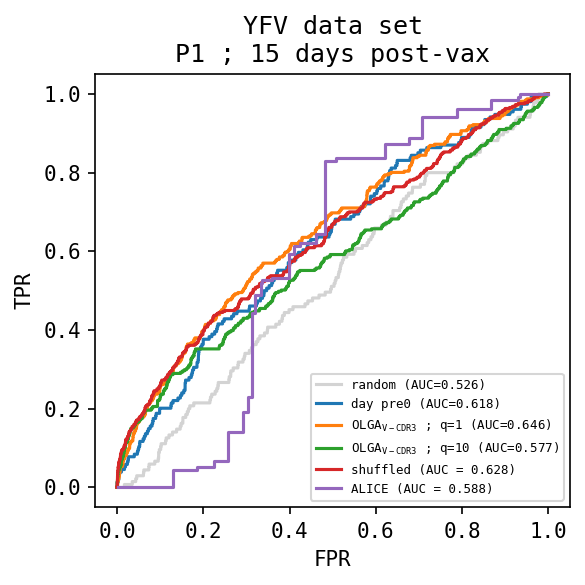

In [23]:
fig, ax = plt.subplots(dpi=150, figsize=(4,4))

fpr, tpr = get_metrics(baseline_annot)
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, c="lightgrey", label=f"random (AUC={auroc})")

fpr, tpr = get_metrics(p_annot)
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, label=f"day pre0 (AUC={auroc})")

fpr, tpr = get_metrics(vhits_1_annot)
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, label=r"$\mathregular{OLGA_{V-CDR3}}$ ; q=1 (AUC=%s)" % (auroc))

fpr, tpr = get_metrics(vhits_10_annot)
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, label=r"$\mathregular{OLGA_{V-CDR3}}$ ; q=10 (AUC=%s)" % (auroc))

fpr, tpr = get_metrics(shuff_annot)
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, label=f"shuffled (AUC = {auroc})")

fpr, tpr = get_metrics(alice_annot)
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, label=f"ALICE (AUC = {auroc})")

ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_title("YFV data set\nP1 ; 15 days post-vax")
ax.legend(fontsize=6)
fig.tight_layout()

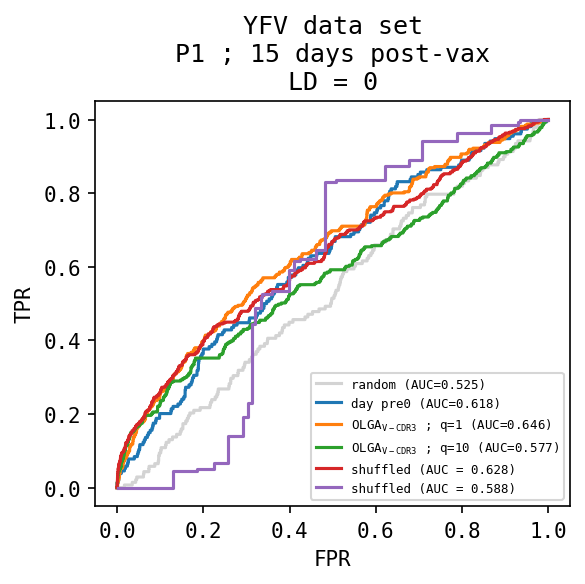

In [27]:
cutoff = 0

fig, ax = plt.subplots(dpi=150, figsize=(4,4))

baseline["hit"] = baseline.ld.apply(lambda x: identify_neighbors(x, d=cutoff))
fpr, tpr = get_metrics(baseline, target_col="hit")
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, c="lightgrey", label=f"random (AUC={auroc})")

p["hit"] = p.ld.apply(lambda x: identify_neighbors(x, d=cutoff))
fpr, tpr = get_metrics(p, target_col="hit")
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, label=f"day pre0 (AUC={auroc})")

vhits_1["hit"] = vhits_1.ld.apply(lambda x: identify_neighbors(x, d=cutoff))
fpr, tpr = get_metrics(vhits_1, target_col="hit")
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, label=r"$\mathregular{OLGA_{V-CDR3}}$ ; q=1 (AUC=%s)" % (auroc))

vhits_10["hit"] = vhits_10.ld.apply(lambda x: identify_neighbors(x, d=cutoff))
fpr, tpr = get_metrics(vhits_10, target_col="hit")
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, label=r"$\mathregular{OLGA_{V-CDR3}}$ ; q=10 (AUC=%s)" % (auroc))

shuff["hit"] = shuff.ld.apply(lambda x: identify_neighbors(x, d=cutoff))
fpr, tpr = get_metrics(shuff, target_col="hit")
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, label=f"shuffled (AUC = {auroc})")

p1_15_alice["hit"] = p1_15_alice.ld.apply(lambda x: identify_neighbors(x, d=cutoff))
fpr, tpr = get_metrics(p1_15_alice, target_col="hit")
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, label=f"shuffled (AUC = {auroc})")

ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_title(f"YFV data set\nP1 ; 15 days post-vax\nLD = {cutoff}")
ax.legend(fontsize=6)
fig.tight_layout()
fig.savefig("./fig/roc_auc_P1_15_LD_0.png", format="png", dpi=500)

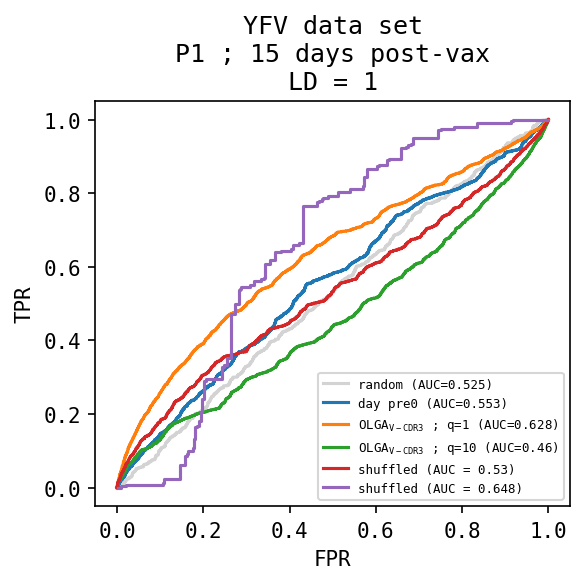

In [25]:
cutoff = 1

fig, ax = plt.subplots(dpi=150, figsize=(4,4))

baseline["hit"] = baseline.ld.apply(lambda x: identify_neighbors(x, d=cutoff))
fpr, tpr = get_metrics(baseline, target_col="hit")
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, c="lightgrey", label=f"random (AUC={auroc})")

p["hit"] = p.ld.apply(lambda x: identify_neighbors(x, d=cutoff))
fpr, tpr = get_metrics(p, target_col="hit")
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, label=f"day pre0 (AUC={auroc})")

vhits_1["hit"] = vhits_1.ld.apply(lambda x: identify_neighbors(x, d=cutoff))
fpr, tpr = get_metrics(vhits_1, target_col="hit")
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, label=r"$\mathregular{OLGA_{V-CDR3}}$ ; q=1 (AUC=%s)" % (auroc))

vhits_10["hit"] = vhits_10.ld.apply(lambda x: identify_neighbors(x, d=cutoff))
fpr, tpr = get_metrics(vhits_10, target_col="hit")
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, label=r"$\mathregular{OLGA_{V-CDR3}}$ ; q=10 (AUC=%s)" % (auroc))

shuff["hit"] = shuff.ld.apply(lambda x: identify_neighbors(x, d=cutoff))
fpr, tpr = get_metrics(shuff, target_col="hit")
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, label=f"shuffled (AUC = {auroc})")

p1_15_alice["hit"] = p1_15_alice.ld.apply(lambda x: identify_neighbors(x, d=cutoff))
fpr, tpr = get_metrics(p1_15_alice, target_col="hit")
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, label=f"shuffled (AUC = {auroc})")

ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_title(f"YFV data set\nP1 ; 15 days post-vax\nLD = {cutoff}")
ax.legend(fontsize=6)
fig.tight_layout()
fig.savefig("./fig/roc_auc_P1_15_LD_1.png", format="png", dpi=500)

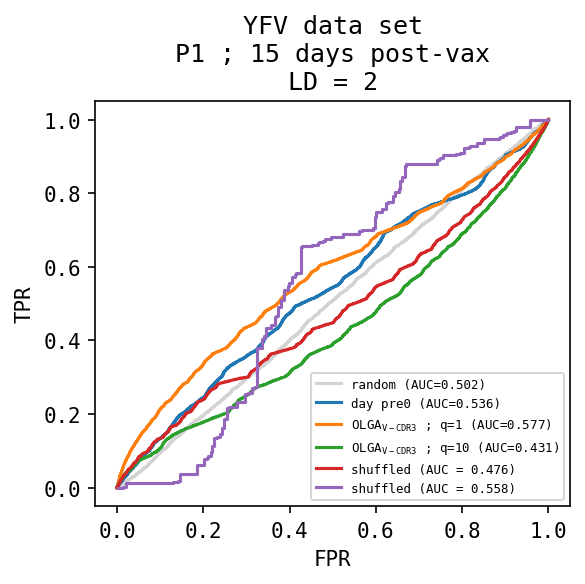

In [26]:
cutoff = 2

fig, ax = plt.subplots(dpi=150, figsize=(4,4))

baseline["hit"] = baseline.ld.apply(lambda x: identify_neighbors(x, d=cutoff))
fpr, tpr = get_metrics(baseline, target_col="hit")
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, c="lightgrey", label=f"random (AUC={auroc})")

p["hit"] = p.ld.apply(lambda x: identify_neighbors(x, d=cutoff))
fpr, tpr = get_metrics(p, target_col="hit")
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, label=f"day pre0 (AUC={auroc})")

vhits_1["hit"] = vhits_1.ld.apply(lambda x: identify_neighbors(x, d=cutoff))
fpr, tpr = get_metrics(vhits_1, target_col="hit")
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, label=r"$\mathregular{OLGA_{V-CDR3}}$ ; q=1 (AUC=%s)" % (auroc))

vhits_10["hit"] = vhits_10.ld.apply(lambda x: identify_neighbors(x, d=cutoff))
fpr, tpr = get_metrics(vhits_10, target_col="hit")
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, label=r"$\mathregular{OLGA_{V-CDR3}}$ ; q=10 (AUC=%s)" % (auroc))

shuff["hit"] = shuff.ld.apply(lambda x: identify_neighbors(x, d=cutoff))
fpr, tpr = get_metrics(shuff, target_col="hit")
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, label=f"shuffled (AUC = {auroc})")

p1_15_alice["hit"] = p1_15_alice.ld.apply(lambda x: identify_neighbors(x, d=cutoff))
fpr, tpr = get_metrics(p1_15_alice, target_col="hit")
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, label=f"shuffled (AUC = {auroc})")

ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_title(f"YFV data set\nP1 ; 15 days post-vax\nLD = {cutoff}")
ax.legend(fontsize=6)
fig.tight_layout()
fig.savefig("./fig/roc_auc_P1_15_LD_2.png", format="png", dpi=500)

#### TCRDist = 12.5 vs TCRDist = 24

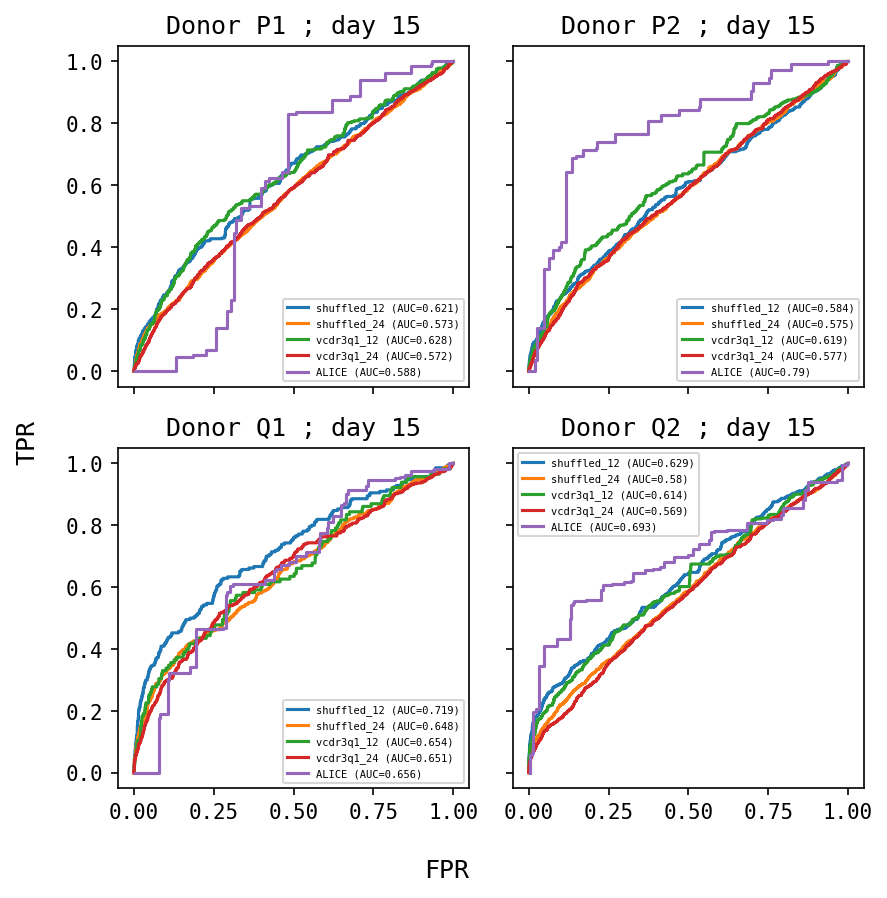

In [14]:
donors = ["P1","P2","Q1","Q2"]
conditions = ["shuffled_12","shuffled_24","vcdr3q1_12","vcdr3q1_24"]
fig, axes = plt.subplots(dpi=150,figsize=(6,6),nrows=2,ncols=2,sharex=True,sharey=True)

for donor, ax in zip(donors, axes.ravel()):
    
    for condition in conditions:
        df = pd.read_csv(f"./analysis/test/distances/{donor}_15_F1_{condition}_hits.txt", sep="\t", index_col=[0])
        df_annot = annotate_results(df, responding)
        df_annot["pval_corr"] = fdrcorrection(df.pval, alpha=0.05, method='indep', is_sorted=False)[1]
        # df_annot = df_annot[df_annot.pval_corr<.05]
        fpr, tpr = get_metrics(df_annot, target_col="responding")
        auroc = np.round(auc(fpr,tpr),3)
        ax.plot(fpr, tpr, label=f"{condition} (AUC={auroc})")

    donor_alice = alice[alice.donor==f"{donor}_15_F1"].sort_values(by="pval")
    donor_alice = annotate_results(donor_alice, responding)
    # fig, ax = plt.subplots(dpi=150, figsize=(4,4))

    fpr, tpr = get_metrics(donor_alice, target_col="responding")
    auroc = np.round(auc(fpr,tpr),3)
    ax.plot(fpr, tpr, label=f"ALICE (AUC={auroc})")

    ax.set_title(f"Donor {donor} ; day 15")
    ax.legend(fontsize=5)

fig.supxlabel("FPR")
fig.supylabel("TPR")
fig.tight_layout()

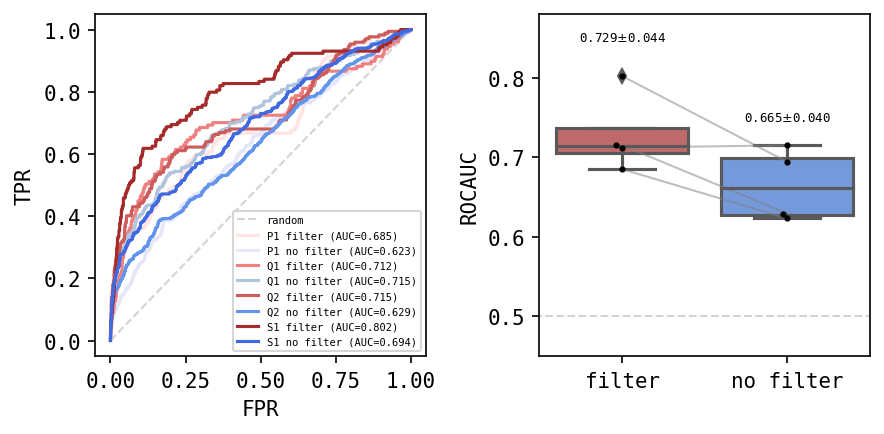

In [209]:
donors = ["P1","Q1","Q2","S1"]
d = "12_2"
sign = False
cutoff = .2

fig, ax = plt.subplots(dpi=150,figsize=(6,3),ncols=2)
colors_red = ["mistyrose","lightcoral","indianred","brown"]
colors_blue = ["lavender","lightsteelblue","cornflowerblue","royalblue"]

red_auc = []
blue_auc = []

ax[0].plot([0,1],[0,1],color="lightgrey",ls="--",lw=1,label="random")

for n, donor in enumerate(donors):

    df = pd.read_csv(f"./analysis/test/{donor}_15_F1_shuffled_{d}_hits.txt", sep="\t", index_col=[0])
    df = annotate_results(df, responding)
    df = df[df.foreground_neighbors>0]
    df_fg = df.sort_values("pval", ascending=True)
    df["score"] = ((df.background_neighbors/10)/df.foreground_neighbors)
    df = df[df.score<cutoff]
    df["pval_corr"] = fdrcorrection(df.pval, alpha=0.05, method='indep', is_sorted=False)[1]
    if sign:
        df = df[df.pval_corr<.05]
        df_fg["pval_corr"] = fdrcorrection(df_fg.pval, alpha=0.05)[1]
        df_fg = df_fg[df_fg.pval_corr<.05]
    fpr, tpr = get_metrics(df, target_col="responding")
    auroc = np.round(auc(fpr,tpr),3)
    red_auc.append(auroc)
    ax[0].plot(fpr, tpr, label=f"{donor} filter (AUC={auroc})",c=colors_red[n])

    fpr, tpr = get_metrics(df_fg, target_col="responding")
    auroc = np.round(auc(fpr,tpr),3)
    blue_auc.append(auroc)
    ax[0].plot(fpr, tpr, label=f"{donor} no filter (AUC={auroc})",c=colors_blue[n])

ax[0].legend(fontsize=5)
ax[0].set_xlabel("FPR")
ax[0].set_ylabel("TPR")

results = pd.DataFrame(
    {"ranking":["p-value"]*4+["neighbor"]*4,
    "rocauc":red_auc+blue_auc,
    "donor":donors+donors})

# fig, ax = plt.subplots(dpi=150,figsize=(3,3))
cpal = {"p-value":"indianred","neighbor":"cornflowerblue"}
sns.boxplot(x="ranking",y="rocauc",data=results,ax=ax[1],palette=cpal)
sns.lineplot(x="ranking",y="rocauc",data=results,ax=ax[1],units="donor",estimator=None,c="grey",lw=1,alpha=.5)
sns.swarmplot(x="ranking",y="rocauc",data=results,s=3,c="black")

ax[1].text(
    x=0,y=.85,
    s=f"{np.average(red_auc):.3f}$\pm${np.std(red_auc):.3f}",
    ha='center', va='center',
    fontsize=6
    )

ax[1].text(
    x=1,y=.75,
    s=f"{np.average(blue_auc):.3f}$\pm${np.std(blue_auc):.3f}",
    ha='center', va='center',
    fontsize=6
    )

ax[1].set_ylabel("ROCAUC")
ax[1].set_xlabel("")
ax[1].set_ylim(.45,.88)
ax[1].set_xlim(-.5,1.5)
ax[1].hlines(.5,xmin=-1,xmax=2,color="lightgrey",ls="--",lw=1)

ax[1].set_xticklabels(["filter", "no filter"])

fig.tight_layout()
# fig.savefig(f"./fig/pval_vs_neighbor_rank_tcrdist_{d}.png", format="png", dpi=500)

1
0.5
0.2
0.1
0.05


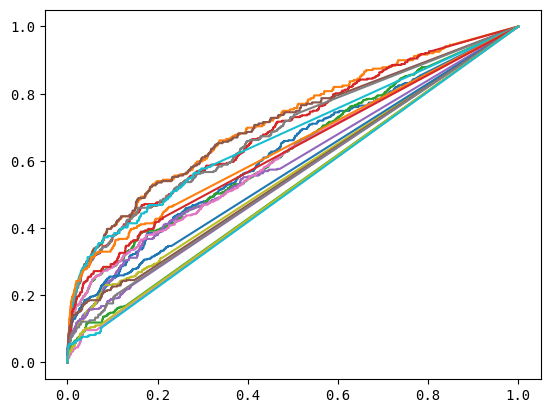

In [219]:
cutoffs = [1,.5,.2,.1,.05]
final = {}
sign = False

for cutoff in cutoffs:
    print(cutoff)
    aucs = []
    for n, donor in enumerate(donors):
        df = pd.read_csv(f"./analysis/test/{donor}_15_F1_shuffled_{d}_hits.txt", sep="\t", index_col=[0])
        df = annotate_results(df, responding)
        df = df[df.foreground_neighbors>0]
        df["score"] = ((df.background_neighbors/10)/df.foreground_neighbors)
        df.loc[df['score']>cutoff,"pval"] = 1
        df = df.sort_values(by="pval")
        # df = df[df.score<cutoff]
        df["pval_corr"] = fdrcorrection(df.pval, alpha=0.05, method='indep', is_sorted=False)[1]
        if sign:
            df = df[df.pval_corr<.05]
        fpr, tpr = get_metrics(df, target_col="responding")
        auroc = np.round(auc(fpr,tpr),3)
        aucs.append(auroc)
        # plt.plot(fpr,tpr)
    final[cutoff] = aucs
    # ax[0].plot(fpr, tpr, label=f"{donor} filter (AUC={auroc})",c=colors_red[n])

1
0.5
0.2
0.1
0.05


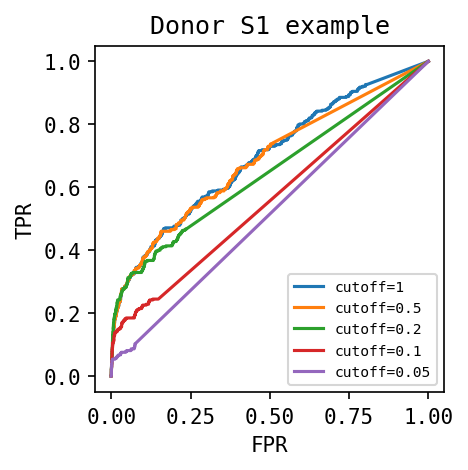

In [223]:
cutoffs = [1,.5,.2,.1,.05]
final = {}
sign = False

fig, ax = plt.subplots(dpi=150,figsize=(3,3))

for cutoff in cutoffs:
    print(cutoff)
    df = pd.read_csv(f"./analysis/test/S1_15_F1_shuffled_{d}_hits.txt", sep="\t", index_col=[0])
    df = annotate_results(df, responding)
    df = df[df.foreground_neighbors>0]
    df["score"] = ((df.background_neighbors/10)/df.foreground_neighbors)
    df.loc[df['score']>cutoff,"pval"] = 1
    df = df.sort_values(by="pval")
    # df = df[df.score<cutoff]
    df["pval_corr"] = fdrcorrection(df.pval, alpha=0.05, method='indep', is_sorted=False)[1]
    if sign:
        df = df[df.pval_corr<.05]
    fpr, tpr = get_metrics(df, target_col="responding")
    auroc = np.round(auc(fpr,tpr),3)
    aucs.append(auroc)
    ax.plot(fpr,tpr,label=f"cutoff={cutoff}")
ax.set_title("Donor S1 example")
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.legend(fontsize=7)

<AxesSubplot: xlabel='cutoff', ylabel='rocauc'>

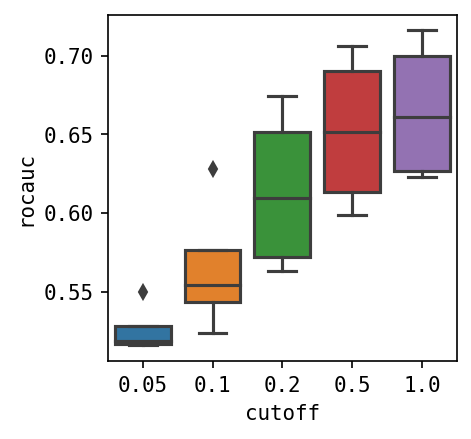

In [220]:
final_df = pd.melt(pd.DataFrame(final),var_name="cutoff",value_name="rocauc")
# final_

fig, ax = plt.subplots(dpi=150,figsize=(3,3))
sns.boxplot(data=final_df, x="cutoff", y="rocauc",ax=ax)

In [231]:
df = pd.read_csv(f"./analysis/test/{donor}_15_F1_shuffled_{d}_hits.txt", sep="\t", index_col=[0])
df = annotate_results(df, responding)
df = df[df.foreground_neighbors>0]
df["score"] = ((df.background_neighbors/10+1)/df.foreground_neighbors)
# df = df[df.score<cutoff]


# df.apply(lambda x: 1 if x["score"] > cutoff else x["pval"])

In [243]:
cutoffs = [1,.5,.2,.1,.05]
final = {}
sign = False

aucs = []
for n, donor in enumerate(donors):
    df = pd.read_csv(f"./analysis/test/{donor}_15_F1_shuffled_{d}_hits.txt", sep="\t", index_col=[0])
    df = annotate_results(df, responding)
    df = df[df.foreground_neighbors>0]
    df = df.drop_duplicates()
    df["score"] = ((df.background_neighbors/10+1)/df.foreground_neighbors)
    # df.loc[df['score']>cutoff,"pval"] = 1
    # df = df.sort_values(by="pval")
    df["comp_p"] = df.pval / df["score"]
    df = df.sort_values("pval")
    # df = df[df.score<cutoff]
    # df["pval_corr"] = fdrcorrection(df.pval, alpha=0.05, method='indep', is_sorted=False)[1]
    # if sign:
    #     df = df[df.pval_corr<.05]
    fpr, tpr = get_metrics(df, target_col="responding")
    auroc = np.round(auc(fpr,tpr),3)
    aucs.append(auroc)
    # plt.plot(fpr,tpr)

In [244]:
aucs

[0.623, 0.715, 0.629, 0.694]

In [242]:
aucs

[0.602, 0.707, 0.621, 0.676]

In [204]:
def get_metrics(df, target_col="responding"):
    fp = 0
    tp = 0
    fpr = []
    tpr = []
    for i in df.iterrows():
        if i[1].pval == 1:
            break
        else:
            if i[1][target_col] == False:
                fp += 1
            else:
                tp += 1
            fpr.append(fp)
            tpr.append(tp)
    N = df[target_col].value_counts()[False]
    P = df[target_col].value_counts()[True]
    fpr = [i/N for i in fpr]
    tpr = [i/P for i in tpr]
    fpr.append(1)
    tpr.append(1)

    return fpr, tpr

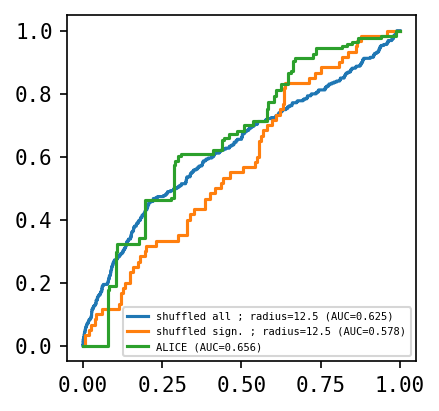

In [36]:
donor = "Q1"
d = "17"

df = pd.read_csv(f"./analysis/test/{donor}_15_F1_shuffled_{d}_hits.txt", sep="\t", index_col=[0])
df = annotate_results(df, responding)
df = df[df.foreground_neighbors>0]
df = df.sort_values("foreground_neighbors", ascending=False)

df["pval_corr"] = fdrcorrection(df.pval, alpha=0.05, method='indep', is_sorted=False)[1]
df_filtered = df[df.pval_corr<.05]

fig, ax = plt.subplots(dpi=150,figsize=(3,3))

fpr, tpr = get_metrics(df, target_col="responding")
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, label=f"shuffled all ; radius=12.5 (AUC={auroc})")

fpr, tpr = get_metrics(df_filtered, target_col="responding")
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, label=f"shuffled sign. ; radius=12.5 (AUC={auroc})")

donor_alice = alice[alice.donor==f"{donor}_15_F1"].sort_values(by="pval")
donor_alice = annotate_results(donor_alice, responding)

fpr, tpr = get_metrics(donor_alice, target_col="responding")
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, label=f"ALICE (AUC={auroc})")

ax.legend(fontsize=5)



,v_call,junction_aa,foreground_neighbors,background_neighbors,pval,v_gene,responding,pval_corr
5915,TRBV5-1*01,CASSLGGNTEAFF,112,879,0.010618,TRBV5-1,False,0.208042
8280,TRBV12-3*01,CASSLGGNTEAFF,111,895,0.020504,TRBV12-3,False,0.287000
19207,TRBV12-3*01,CASSLGNEQFF,108,936,0.089395,TRBV12-3,False,0.476673
2234,TRBV12-3*01,CASSLGETQYF,106,765,0.001434,TRBV12-3,False,0.074349
850,TRBV12-3*01,CASSLGMNTEAFF,105,691,0.000087,TRBV12-3,False,0.011805
...,...,...,...,...,...,...,...,...
70130,TRBV12-3*01,CASKPRGGNYEQYF,1,6,0.486842,TRBV12-3,False,0.786102
70131,TRBV12-3*01,CASSLWGWGQPQHF,1,6,0.486842,TRBV12-3,False,0.786102
70132,TRBV12-3*01,CASSRPGAGYNEQFF,1,6,0.486842,TRBV12-3,False,0.786102
70133,TRBV7-9*01,CASSPPTQYNEQFF,1,6,0.486842,TRBV7-9,False,0.786102


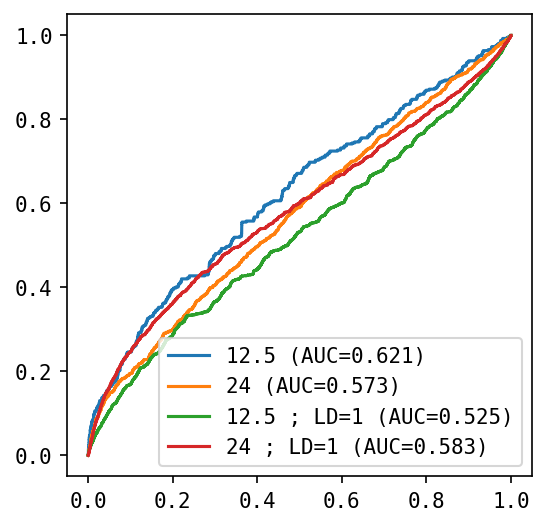

In [30]:
fig, ax = plt.subplots(dpi=150, figsize=(4,4))

df_12_annot["hit"] = df_12_annot.ld.apply(lambda x: identify_neighbors(x, d=0))
fpr, tpr = get_metrics(df_12_annot, target_col="responding")
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, label=f"12.5 (AUC={auroc})")

df_12_annot["hit"] = df_12_annot.ld.apply(lambda x: identify_neighbors(x, d=0))
fpr, tpr = get_metrics(df_24_annot, target_col="responding")
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, label=f"24 (AUC={auroc})")

df_12_annot["hit"] = df_12_annot.ld.apply(lambda x: identify_neighbors(x, d=1))
fpr, tpr = get_metrics(df_12_annot, target_col="hit")
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, label=f"12.5 ; LD=1 (AUC={auroc})")

df_24_annot["hit"] = df_24_annot.ld.apply(lambda x: identify_neighbors(x, d=1))
fpr, tpr = get_metrics(df_24_annot, target_col="hit")
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, label=f"24 ; LD=1 (AUC={auroc})")

ax.legend()

In [38]:
pval = .5

sign = P2_shuff_annot[P2_shuff_annot.pval_corr<pval]
nonsign = P2_shuff_annot[P2_shuff_annot.pval_corr>pval]

FP, TP = sign.responding.value_counts().values
TN, FN = nonsign.responding.value_counts().values

sensitivity = TP/(TP+FN)
specificity = TN/(TN+FP)

print("sensitivity",sensitivity)
print("specificity",specificity)

# sensitivity = 

sensitivity 0.2807486631016043
specificity 0.8568583838924924


In [121]:
sign

,v_call,junction_aa,foreground_neighbors,background_neighbors,pval,v_gene,responding,pval_corr,log_p


In [23]:
donors = ["P1","P2","Q1","Q2"]
log = False
# fig, ax = plt.subplots(dpi=150,figsize=(5,3))

sensitivity_shuf = {donor:[] for donor in donors}
specificity_shuf = {donor:[] for donor in donors}

for donor in donors:

    df = pd.read_csv(f"./analysis/test/distances/{donor}_15_F1_shuffled_12_hits.txt", sep="\t", index_col=[0])
    df = annotate_results(df, responding)
    df["pval_corr"] = fdrcorrection(df.pval, alpha=0.05, method='indep', is_sorted=False)[1]
    df["log_p"] = -np.log10(df.pval_corr)

    if log:
        pvals = np.arange(30,0,-.05)
    else:
        pvals = np.arange(1e-5,1,0.005)

    for pval in pvals:

        if log:
            sign = df[df.log_p>pval]
            nonsign = df[df.log_p<pval]
        else:
            sign = df[df.pval_corr<pval]
            nonsign = df[df.pval_corr>pval]

        try:
            FP, TP = sign.responding.value_counts().values
        except ValueError:
            c = sign.responding.values[0]
            if c == False:
                FP = sign.responding.value_counts().values
            else:
                TP = sign.responding.value_counts().values
        try:
            TN, FN = nonsign.responding.value_counts().values
        except ValueError:
            TN = nonsign.responding.value_counts().values

        sensitivity_shuf[donor].append(TP/(TP+FN))
        specificity_shuf[donor].append(TN/(TN+FP))

#     ax.plot(pvals,specificity,label=f"{donor}, specificity")
#     ax.plot(pvals,sensitivity,label=f"{donor}, sensitivity")

# ax.set_xlabel("p-value")
# ax.set_ylabel("metric")
# ax.legend(fontsize=8, bbox_to_anchor=[1,.8])
# fig.tight_layout()

In [140]:
from raptcr.constants.parsing import _is_cdr3

responding = pd.read_csv("./analysis/background_testing/yfv/yfv_responding.txt", sep="\t")
responding = responding[["bestVGene","CDR3.amino.acid.sequence","donor"]].drop_duplicates()
responding.columns = ["v_gene","junction_aa","donor"]
responding["responding"] = "red"

don = responding[responding.donor=="Q2"]
resp = don[don.junction_aa.apply(lambda x: _is_cdr3(x))]

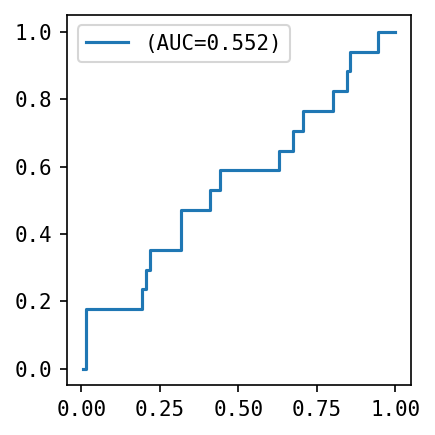

In [157]:
donor = "Q1"

responding = pd.read_csv("./analysis/background_testing/yfv/yfv_responding.txt", sep="\t")
responding = responding[["bestVGene","CDR3.amino.acid.sequence","donor"]].drop_duplicates()
responding.columns = ["v_gene","junction_aa","donor"]
responding["responding"] = "red"

don = responding[responding.donor==donor]
resp = don[don.junction_aa.apply(lambda x: _is_cdr3(x))]

df = pd.read_csv(f"./analysis/test/distances/{donor}_15_F1_shuffled_12_hits.txt", sep="\t", index_col=[0])

df = annotate_results(df, resp)
df["pval_corr"] = fdrcorrection(df.pval, alpha=0.05, method='indep', is_sorted=False)[1]
df = df[df.pval_corr<.05]

fig, ax = plt.subplots(dpi=150,figsize=(3,3))
fpr, tpr = get_metrics(df, target_col="responding")
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, label=f"(AUC={auroc})")
ax.legend()
fig.tight_layout()

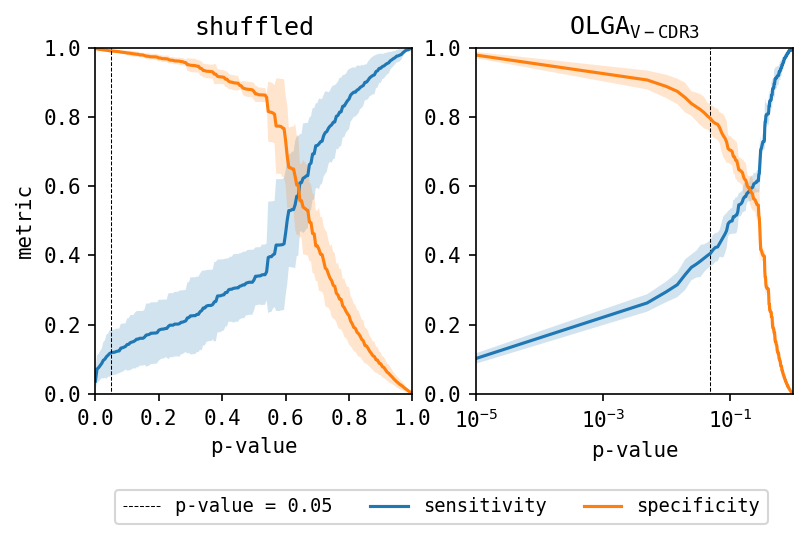

In [63]:
fig, ax = plt.subplots(dpi=150,figsize=(6,3),nrows=1,ncols=2)

sens_avg = pd.DataFrame(sensitivity_shuf).mean(axis=1)
sens_std = pd.DataFrame(sensitivity_shuf).std(axis=1)
spec_avg = pd.DataFrame(specificity_shuf).mean(axis=1)
spec_std = pd.DataFrame(specificity_shuf).std(axis=1)

ax[0].fill_between(pvals,y1=sens_avg+sens_std,y2=sens_avg-sens_std,alpha=.2)
ax[0].plot(pvals,sens_avg,label="sensitivity")

ax[0].fill_between(pvals,y1=spec_avg+spec_std,y2=spec_avg-spec_std,alpha=.2)
ax[0].plot(pvals,spec_avg,label="specificity")

ax[0].vlines(.05, ymin=-.2,ymax=1.2,lw=.5,color="black",ls="--")
ax[1].vlines(.05, ymin=-.2,ymax=1.2,lw=.5,color="black",ls="--",label="p-value = 0.05")

# ax.plot(pvals,sensitivity,label="sensitivity")

ax[0].set_xlabel("p-value")
ax[0].set_ylabel("metric")
# ax[0].set_xscale("log")
ax[0].set_xlim(0,1)
ax[0].set_ylim(0,1)
ax[1].set_xlim(1e-5,1e-0)
ax[1].set_ylim(0,1)
ax[0].set_title("shuffled")
ax[1].set_title(r"$\mathregular{OLGA_{V-CDR3}}$")


sens_avg = pd.DataFrame(sensitivity_vcdr3).mean(axis=1)
sens_std = pd.DataFrame(sensitivity_vcdr3).std(axis=1)
spec_avg = pd.DataFrame(specificity_vcdr3).mean(axis=1)
spec_std = pd.DataFrame(specificity_vcdr3).std(axis=1)

ax[1].fill_between(pvals,y1=sens_avg+sens_std,y2=sens_avg-sens_std,alpha=.2)
ax[1].plot(pvals,sens_avg,label="sensitivity")

ax[1].fill_between(pvals,y1=spec_avg+spec_std,y2=spec_avg-spec_std,alpha=.2)
ax[1].plot(pvals,spec_avg,label="specificity")

ax[1].set_xlabel("p-value")
ax[1].set_xscale("log")

ax[1].legend(bbox_to_anchor=(.95, -.25),ncol=3, fancybox=True, fontsize=9)

# fig.tight_layout()
fig.savefig("./fig/sensitivity_specificity_backgrounds.png", format="png", dpi=500, bbox_inches="tight")

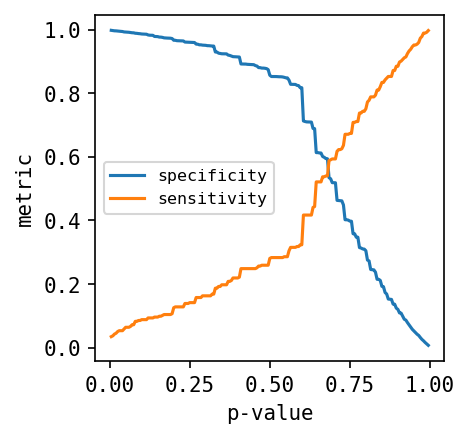

In [51]:
fig, ax = plt.subplots(dpi=150,figsize=(3,3))

ax.plot(pvals,specificity,label="specificity")
ax.plot(pvals,sensitivity,label="sensitivity")

ax.set_xlabel("p-value")
ax.set_ylabel("metric")

ax.legend(fontsize=8)

In [163]:
donors = ["P1","P2","S1","S2","Q1","Q2"]

pooled = pd.concat([parse_yfv_repertoires(f"./data/yfv/{donor}_15_F1_.txt.gz") for donor in donors])
background_generator = SyntheticBackground(repertoire=pooled, n=1)
pooled_shuffled = background_generator.shuffled_repertoire(factor=10)

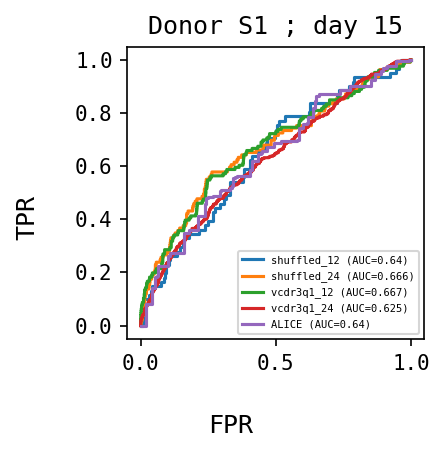

In [13]:
from statsmodels.stats.multitest import fdrcorrection
correct = True

donors = ["P1","P2","Q1","Q2"]
conditions = ["shuffled_12","shuffled_24","vcdr3q1_12","vcdr3q1_24"]
fig, ax = plt.subplots(dpi=150,figsize=(3,3))

# for donor, ax in zip(donors, axes.ravel()):
    
for condition in conditions:
    df = pd.read_csv(f"./analysis/test/distances/S1_15_F1_{condition}_hits.txt", sep="\t", index_col=[0])
    df_annot = annotate_results(df, responding)
    if correct:
        df_annot["pval_corr"] = fdrcorrection(df.pval, alpha=0.05, method='indep', is_sorted=False)[1]
        df_annot = df_annot[df_annot.pval_corr<.05]
    fpr, tpr = get_metrics(df_annot, target_col="responding")
    auroc = np.round(auc(fpr,tpr),3)
    ax.plot(fpr, tpr, label=f"{condition} (AUC={auroc})")

donor_alice = alice[alice.donor==f"S1_15_F1"].sort_values(by="pval")
donor_alice = annotate_results(donor_alice, responding)
# fig, ax = plt.subplots(dpi=150, figsize=(4,4))

fpr, tpr = get_metrics(donor_alice, target_col="responding")
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, label=f"ALICE (AUC={auroc})")

ax.set_title(f"Donor S1 ; day 15")
ax.legend(fontsize=5)

fig.supxlabel("FPR")
fig.supylabel("TPR")
fig.tight_layout()

In [64]:
pooled = pd.read_csv("./analysis/test/pooled_results_12.txt", sep="\t")

In [70]:
pval = .05

pooled["pval_corr"] = fdrcorrection(pooled.pval)[0]
pooled = annotate_results(pooled, responding)

sign = pooled[pooled.pval_corr<pval]
nonsign = pooled[pooled.pval_corr>pval]

FP, TP = sign.responding.value_counts().values
TN, FN = nonsign.responding.value_counts().values

sensitivity = TP/(TP+FN)
specificity = TN/(TN+FP)

print("sensitivity",sensitivity)
print("specificity",specificity)

sensitivity 0.8565005620082428
specificity 0.033329537713478644


In [72]:
specificity = []
sensitivity = []

df = pd.read_csv("./analysis/test/pooled_results_12.txt", sep="\t")
df = annotate_results(df, responding)
df["pval_corr"] = fdrcorrection(df.pval, alpha=0.05, method='indep', is_sorted=False)[1]
df["log_p"] = -np.log10(df.pval_corr)

pvals = np.arange(1e-5,1,0.005)

for pval in pvals:

    if log:
        sign = df[df.log_p>pval]
        nonsign = df[df.log_p<pval]
    else:
        sign = df[df.pval_corr<pval]
        nonsign = df[df.pval_corr>pval]

    try:
        FP, TP = sign.responding.value_counts().values
    except ValueError:
        c = sign.responding.values[0]
        if c == False:
            FP = sign.responding.value_counts().values
        else:
            TP = sign.responding.value_counts().values
    try:
        TN, FN = nonsign.responding.value_counts().values
    except ValueError:
        TN = nonsign.responding.value_counts().values

    sensitivity.append(TP/(TP+FN))
    specificity.append(TN/(TN+FP))

#     ax.plot(pvals,specificity,label=f"{donor}, specificity")
#     ax.plot(pvals,sensitivity,label=f"{donor}, sensitivity")

# ax.set_xlabel("p-value")
# ax.set_ylabel("metric")
# ax.legend(fontsize=8, bbox_to_anchor=[1,.8])
# fig.tight_layout()

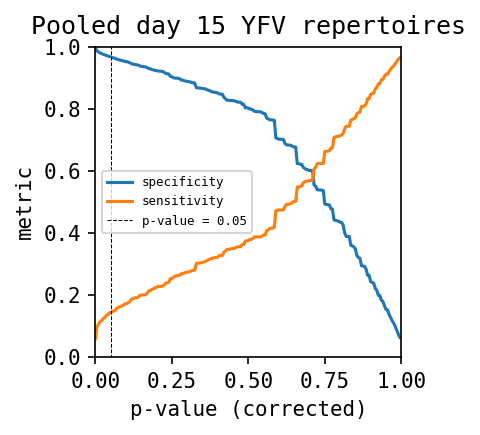

In [84]:
fig, ax = plt.subplots(dpi=150, figsize=(3,3))

ax.plot(pvals,specificity,label="specificity")
ax.plot(pvals,sensitivity,label="sensitivity")
ax.vlines(.05, ymin=-.2,ymax=1.2,lw=.5,color="black",ls="--",label="p-value = 0.05")

ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_xlabel("p-value (corrected)")
ax.set_ylabel("metric")
ax.set_title("Pooled day 15 YFV repertoires")
ax.legend(fontsize=6)
fig.tight_layout()
fig.savefig()

In [89]:
df[df.pval_corr<0.05].responding.value_counts()

False    16684
True       383
Name: responding, dtype: int64

In [12]:
df = parse_yfv_repertoires("./data/yfv/P1_15_F1_.txt.gz")
df = df.sample(50000)

bg = pd.read_csv("./analysis/background_testing/yfv/shuffled/P1_15_F1_.txt",sep="\t").sample(500000)

encoder = TCRDistEncoder().fit()
nbr_cntr = NeighborEnrichment(repertoire=df,hasher=encoder,radius=12.5)
nbr_cntr.compute_neighbors()

index = FlatIndex(hasher=encoder)
index.add(bg)
nbr_cntr.bg_index = index
nbr_cntr.compute_pvalues(prefilter=False)

Using background of size 500000.
Computing neighbor counts in background for 49810 sequences.
Performing hypergeometric testing.


,v_call,junction_aa,foreground_neighbors,background_neighbors,pval
7999,TRBV29-1*01,CSVAGRMNTEAFF,6,0,5.642584e-07
6753,TRBV29-1*01,CSAAGRMNTEAFF,6,0,5.642584e-07
13464,TRBV5-1*01,CASSLEGQVNQPQHF,6,1,3.642071e-06
10802,TRBV10-3*01,CAISGTGQETQYF,6,2,1.343523e-05
967,TRBV29-1*01,CSVSGRMNTEAFF,4,0,6.828893e-05
...,...,...,...,...,...
7680,TRBV15*01,CATSRTTGNQPQHF,0,0,1.000000e+00
7681,TRBV3-1*01,CASSRPSVFGANVLTF,0,0,1.000000e+00
1712,TRBV12-3*01,CASSLRGGSDTQYF,0,4,1.000000e+00
1713,TRBV29-1*01,CSVNRDKYNEQFF,0,1,1.000000e+00


In [13]:
responding

NameError: name 'responding' is not defined

In [5]:
lim, D, I = index.idx.range_search(X.astype(np.float32), thresh=12.5)

In [6]:
indices = (df['v_call'] + "_" + df['junction_aa']).to_list()

In [11]:
dict([(j, int(lim[i+1]-lim[i])) for i,j in enumerate(indices)])

{'TRBV29-1*01_CSVGDTRTDTQYF': 1,
 'TRBV12-4*01_CASSLTDNYGYTF': 3,
 'TRBV20-1*01_CSARDGGPKETQYF': 1,
 'TRBV11-2*01_CASAPQGNEQFF': 0,
 'TRBV12-3*01_CASSPRGEGQPQHF': 2,
 'TRBV12-4*01_CASSSGLAGYYNEQFF': 0,
 'TRBV20-1*01_CSARDLGQLSSGNTIYF': 1,
 'TRBV12-4*01_CASSGLANYGYTF': 1,
 'TRBV5-1*01_CASSLGGTSGGLTGDTQYF': 0,
 'TRBV27*01_CASSLTTPTYGYTF': 0,
 'TRBV7-6*01_CASSLSPGLSNQPQHF': 0,
 'TRBV7-9*01_CASSFGGDRTDTQYF': 0,
 'TRBV14*01_CASSPTGTYNEQFF': 1,
 'TRBV18*01_CASSPGTGNSPLHF': 6,
 'TRBV10-1*01_CASSGGLAGDSYEQYF': 0,
 'TRBV24-1*01_CATSDQKSGSTDTQYF': 0,
 'TRBV5-1*01_CASSLSSGRETQYF': 7,
 'TRBV5-1*01_CASQGSSYEQYF': 2,
 'TRBV4-1*01_CASSQEGQLRETQYF': 2,
 'TRBV12-3*01_CASSLMGSTDTQYF': 15,
 'TRBV10-3*01_CAIKDRGMDEQFF': 1,
 'TRBV12-3*01_CASLSDGYSNQPQHF': 0,
 'TRBV10-1*01_CASSVGTPLYEQYF': 0,
 'TRBV20-1*01_CSAKQGYTGELFF': 2,
 'TRBV12-3*01_CASSSGDRMTEKLFF': 0,
 'TRBV6-2*01_CASSQRTQYF': 0,
 'TRBV10-2*01_CASSSSGSGDTQYF': 0,
 'TRBV7-2*01_CASSFQARNPEAFF': 0,
 'TRBV15*01_CATSRDRTAGYTF': 0,
 'TRBV11-2*01_CASSPPGKR